In [ ]:
#! pip install pipreqs

In [ ]:
#! pipreqs --encoding=utf-8 c:/Users/Diya/Documents/GItHub/DELTA_Element3

# 0. Import Libraries 

In [1]:
# # For preprocessing
import pandas as pd
import numpy as np
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity
# from collections import Counter
# from imblearn.over_sampling import SMOTE
import nltk
# from nltk.corpus import stopwords
# import re
# from bs4 import BeautifulSoup
# import emoji
# from urllib.parse import urlparse
# import seaborn as sns
# import matplotlib.pyplot as plt

from DataPreprocess import DataPreprocessor

from ClassificationScores import ClassificationEvaluator

# For VaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# For RNN model 
from gensim.models import FastText
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# For DistilBERT
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

# 1. Data Preprocessing

### 1.1. Importing the data and getting known to it.

In [2]:
# Importing the train and test datasets
train_df = pd.read_parquet('btc_tweets_train.parquet.gzip')
test_df = pd.read_parquet('btc_tweets_test.parquet.gzip')

In [3]:
train_df = train_df.reset_index()
test_df = test_df.reset_index()

In [4]:
def df_info(df):
    return df.shape, df.isnull().sum().sum(), df.info(), df.head()

In [5]:
# Running a few checks to understand the datasets
df_info(train_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet ID          1500 non-null   int64 
 1   hashtags          1500 non-null   object
 2   content           1500 non-null   object
 3   username          1500 non-null   object
 4   user_displayname  1500 non-null   object
 5   sentiment         1500 non-null   bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 60.2+ KB


((1500, 6),
 0,
 None,
               tweet ID                                           hashtags  \
 0  1641579121972236290  [Bitcoin, Bitcoin, BTC, Bitcoin, BTC, SHIB, HO...   
 1  1641579176171016194                 [Bitcoin, bitcoinordinals, crypto]   
 2  1641579486071390208  [BTC, SHIB, HOGE, SAITAMA, BNB, DOGE, ETH, Bab...   
 3  1641579537103302656                                              [BTC]   
 4  1641579588399804418                                          [Bitcoin]   
 
                                              content      username  \
 0  $Bitcoin TO $100,000 SOONER THAN YOU THINK‼️💯🙏...   BezosCrypto   
 1  Alright I have my rares. Who else is grabbing ...   spartantc81   
 2  Bitcoin (BTC) Targets Over $100,000 as This Im...   BezosCrypto   
 3  📢 Xverse Web-based pool is live:\n\n•Update @x...  godfred_xcuz   
 4  Yesterday, a Bitcoin projection was displayed ...   goddess81oo   
 
   user_displayname  sentiment  
 0       SHIB Bezos       True  
 1        Spa

In [6]:
df_info(test_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet ID          500 non-null    int64 
 1   hashtags          500 non-null    object
 2   content           500 non-null    object
 3   username          500 non-null    object
 4   user_displayname  500 non-null    object
 5   sentiment         500 non-null    bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 20.1+ KB


((500, 6),
 0,
 None,
               tweet ID                                           hashtags  \
 0  1641861708246552576                                      [crypto, btc]   
 1  1641861783898972167                                 [Bitcoin, Bitcoin]   
 2  1641862152532418562  [Giveaway, BTC, SolanaGiveaways, Giveaway, Air...   
 3  1641862338369183753  [EOS, USDT, BTC, crypto, Bitcoin, etherium, Bi...   
 4  1641862430434131968                        [BTC, ETH, BSC, GroveToken]   
 
                                              content      username  \
 0  #crypto $crypto #btc \nI am Chinese crypto alp...     huahuayjy   
 1  #Bitcoin would have to fall another 80% to rea...  luke_broyles   
 2  #Giveaway $1000 Matic in 3Days\n\n🏆To win\n1️⃣...  cryptomarsdo   
 3  Up or Down?\n\n!!! $EOS #EOS !!!\n\nVS\n\n$USD...  andreyukrnet   
 4  Mid Day Mix-up is LIVE! Never know who might s...    JustAman04   
 
          user_displayname  sentiment  
 0  花花研究院 | Crypto Alpha🇨🇳       True  


In [7]:
# Dropping the unnecessary features (Hashtags in the tweets are seperately handled ahead)
train_df = train_df.drop(['tweet ID', 'user_displayname', 'hashtags'], axis=1)
test_df = test_df.drop(['tweet ID', 'user_displayname', 'hashtags'], axis=1)

In [8]:
# Converting the sentiment labels from bool to int
train_df['sentiment'] = train_df['sentiment'].astype(int)
test_df['sentiment'] = test_df['sentiment'].astype(int)

### A few trials

In [9]:
# def extract_special_characters(text):
#     # Regular expression to match special characters
#     return re.findall(r'[^a-zA-Z0-9\s]', text)

# # Extract special characters from the selected column (e.g., 'content')
# df = train_df.copy()
# df['special_chars'] = df['content'].apply(extract_special_characters)

# # Flatten the list of special characters and count their frequency
# special_chars_list = df['special_chars'].sum()
# special_chars_count = Counter(special_chars_list)

# # Get the most common special characters
# most_common_special_chars = special_chars_count.most_common()

# # Display the results
# for char, count in most_common_special_chars:
#     print(f"'{char}': {count}")

In [10]:
# def extract_emojis(text):
#     return ''.join(char for char in text if char in emoji.EMOJI_DATA)

# # Extract emojis from the selected column (e.g., 'content')
# #column_to_use = 'cleaned_content' if 'cleaned_content' in df.columns else 'content'
# df = train_df.copy()
# df['emojis'] = df['content'].apply(extract_emojis)

# # Flatten the list of emojis and count the frequency of each emoji
# emoji_list = df['emojis'].sum()
# emoji_count = Counter(emoji_list)

# # Get the top 50 most used emojis
# top_50_emojis = emoji_count.most_common(200)

# # Display the results
# for emoji_char, count in top_50_emojis:
#     print(f"{emoji_char}: {count}")


**NOTE: both the cleaned datasets above are still imbalanced with True values largly outnumbered than False. The imbalance needs to be taken care of by assigning class weights dring model training.**

# 2. Benchmark: vaderSentiment Sentiment Dictionary

For sentiment analysis using VADER, it's best to apply VADER to the raw, uncleaned text to leverage its strengths in handling informal language, punctuation, and emojis. However, when it comes to Links, it is best to remove them. Links are irrelevent to the sentiment and could add unnecessary noise, potentially influencing the sentiment.

The preprocessing flow for vaderSentiment
- Remove spam tweets
- Remove links
- Remove unnecessary hashtags
- Then apply vader sentiment dictionary on the cleaned tweets

### 2.1. Getting the dataset ready for VaderSentiment

In [ ]:
vader_test_df = test_df.copy()

In [ ]:
# Getting the dataset ready by removing spam, unnecessary hashtags, links, whitespace and HTML
vader_test_df = test_datapreprocessor.preprocess( remove_spam=True,
                                                  remove_hashtags=True, 
                                                  remove_link=True, 
                                                  remove_whitespace_html=True, 
                                                  remove_emoji=True)

In [ ]:
vader_test_df.head()

In [ ]:
# look over an example to see if the tweets are cleaned as expected
index = 43
vader_test_df['content'].iloc[index], vader_test_df['cleaned_content'].iloc[index], vader_test_df['sentiment'][index]

### 2.2. Fitting the VaderSentiment on processed test data

In [ ]:
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to apply VADER sentiment analysis and get the compound score
def get_sentiment_score(text):
    sentiment_dict = analyzer.polarity_scores(text)
    return sentiment_dict['compound']  # 'compound' score is a normalized score between -1 (negative) and +1 (positive)

# Apply sentiment analysis to the 'content' column and create a new column for the sentiment score
vader_test_df['vader_sentiment'] = vader_test_df['cleaned_content'].apply(get_sentiment_score)

# Classify the sentiment based on the compound score
def classify_sentiment(score):
    if score >= 0:
        return True
    else:
        return False

# Apply the classification and create a new column for the sentiment label
vader_test_df['vader_sentiment_label'] = vader_test_df['vader_sentiment'].apply(classify_sentiment).astype(int)


In [ ]:
vader_test_df.head()

### 2.3. Evaluating the vaderSentiment classification performance

In [ ]:
# Initializing the performance evaluator class for vader
vader_performance_evaluator = ClassificationEvaluator(true_labels=vader_test_df['sentiment'], 
                                                      predicted_labels=vader_test_df['vader_sentiment_label'])

vader_performance_evaluator.evaluate()
vader_performance_evaluator.plot_confusion_matrix()

# 3. RNN 

### 3.1. Getting the dataset ready for training the embeddings

In [ ]:
rnn_train_df = train_datapreprocessor.preprocess(remove_spam=True, remove_hashtags=True, remove_link=True, remove_whitespace_html=True, remove_emoji=True, clean_text=False, balance_classes=False)
rnn_test_df = test_datapreprocessor.preprocess(remove_spam=True, remove_hashtags=True, remove_link=True, remove_whitespace_html=True, remove_emoji=True, clean_text=False, balance_classes=False)

In [ ]:
i = 83
rnn_train_df['content'][i], rnn_train_df['cleaned_content'][i], rnn_train_df['sentiment'][i]

In [ ]:
rnn_train_df.head()

### 3.2. Training the FastText embeddings

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

In [ ]:
# Tokenize the cleaned tweets (split by spaces)
tokenized_tweets = [tweet.split() for tweet in rnn_train_df['cleaned_content']]

# Train FastText model using Gensim's implementation
fasttext_model = FastText(sentences=tokenized_tweets, vector_size=50, window=5, min_count=1, sg=0, epochs=10)

# Save the model
#fasttext_model.save("fasttext_vs50.model")

# Load the model (for future use)
#fasttext_model = FastText.load("fasttext_vs50.model")

In [ ]:
# Example: Get vector for a word 
print(f"Vector for 'bitcoin': {fasttext_model.wv['bitcoin']}")

# Example: Get most similar words
print(f"Words similar to 'bitcoin': {fasttext_model.wv.most_similar('bitcoin')}")

### 3.3. Building and Training the RNN model

 Create a plot to decide on sequence length|

In [ ]:
# Parameters
max_sequence_length = 40
embedding_dim = 50
embedding_matrix = fasttext_model.wv.vectors # Create embedding matrix
vocab_size = len(fasttext_model.wv)

In [ ]:
#fasttext_model.wv.vector_size, len(tokenizer.word_counts), vocab_size, tokenizer.word_index.items()

In [ ]:
# Tokenize the tweets
tokenizer = Tokenizer(num_words=vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(rnn_train_df['cleaned_content'])

# sequences are tweets transformed into arrays where each word is sequentially replaced by a number which corresponds to the index of that word in the vocabulary
train_sequences = tokenizer.texts_to_sequences(rnn_train_df['cleaned_content']) 
padded_train_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')

test_sequences = tokenizer.texts_to_sequences(rnn_test_df['cleaned_content'])
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')

In [ ]:
padded_test_sequences

In [ ]:
# Dimension check
padded_train_sequences.shape, rnn_train_df['sentiment'].shape

In [ ]:
# Split the data to training and validation
X_train, X_val, y_train, y_val = train_test_split(padded_train_sequences, rnn_train_df['sentiment'], test_size = 0.2, random_state = 9)
# Changing the dtype from series to array
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()

# Preparing the test data
rnn_X_test = padded_test_sequences
rnn_y_test = rnn_test_df['sentiment'].to_numpy()

In [ ]:
# Calculate the class weights to handle imbalance
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
class_weights

Study about kernel_regularizer, learning_rate

In [ ]:
from tensorflow.keras.metrics import AUC, Precision, Recall

# Build the RNN model
def build_rnn_model(embd_dim, rnn_type='LSTM'):
    model = Sequential()
    model.add(Input(shape=(max_sequence_length,)))
    model.add(Embedding(input_dim = vocab_size, 
                        output_dim = embd_dim, 
                        weights=[embedding_matrix],  
                        trainable=False))
    
    if rnn_type == 'LSTM':
        model.add(LSTM(units = 64, return_sequences = False, kernel_regularizer=l2(0.02)))
    elif rnn_type == 'GRU':
        model.add(GRU(units = 64, return_sequences= False, kernel_regularizer=l2(0.02)))
        
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid', kernel_regularizer=l2(0.02)))
    
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy']) #, Precision(), Recall(), AUC()])
    return model

In [ ]:
# Initialize the model
model = build_rnn_model(embd_dim=embedding_dim, rnn_type='LSTM')
model.summary()

In [ ]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=25, batch_size=16, validation_data=(X_val, y_val), class_weight=class_weights, callbacks=[early_stopping])

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(rnn_X_test, rnn_y_test)

In [ ]:
# Predicting sentiments on new tweets
rnn_predictions = model.predict(rnn_X_test)
# Convert probabilities to binary predictions
rnn_predictions_discrete = (rnn_predictions >= 0.5).astype(int)  

In [ ]:
# u = 24
# rnn_predictions[u], rnn_predictions_discrete[u], rnn_y_test[u], rnn_test_df['cleaned_content'].iloc[u]

In [ ]:
#rnn_predictions

In [ ]:
# Initializing the performance evaluator class for RNN
rnn_performance_evaluator = ClassificationEvaluator(true_labels=rnn_y_test, 
                                                    predicted_labels=rnn_predictions_discrete, 
                                                    predicted_probs=rnn_predictions)

rnn_performance_evaluator.evaluate()
rnn_performance_evaluator.plot_confusion_matrix()
rnn_performance_evaluator.plot_roc_auc()

# 4. DistilBERT

### 4.1. Data preprocessing: DistilBERT

In [11]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, TextClassificationPipeline, TrainingArguments, Trainer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch

In [12]:
# Initialize the DataPreprocessor class for DistilBERT
dtb_train_datapreprocessor = DataPreprocessor(df=train_df, content_column='content')
dtb_test_datapreprocessor = DataPreprocessor(df=test_df, content_column='content')

In [13]:
dtb_train_df = dtb_train_datapreprocessor.preprocess(remove_spam=True, remove_hashtags=True, remove_emoji=True, remove_link=True, remove_whitespace_html=True)
dtb_test_df = dtb_test_datapreprocessor.preprocess(remove_spam=True, remove_hashtags=True, remove_emoji=True, remove_link=True, remove_whitespace_html=True)

c:\Users\Diya\Documents\GItHub\DELTA_Element3\DataPreprocess.py:114: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  tweet = BeautifulSoup(tweet, 'html.parser').get_text()
c:\Users\Diya\Documents\GItHub\DELTA_Element3\DataPreprocess.py:114: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  tweet = BeautifulSoup(tweet, 'html.parser').get_text()


In [15]:
i = 7
dtb_test_df['content'][i], dtb_test_df['cleaned_content'][i], dtb_test_df['sentiment'][i]

('#Hex launched &amp; gained 11,900%\n(Nomics .com)\n\n#Pulsechain 2 do- 3X of $HEX \n\nWhy?\n\n#PLS -Already has 40k user \n75-85k new Buyer\nOver 60 projects ready\n\nAlmost 80% supply be locked\nBy #OG #Staking #Validator \n\nRetweet ❤️ $PLS ppl\n\n#BTC #BNB #HEX #PLS #PLSX #ETH #Crypto #XRP #USDT https://t.co/ZG3OlPOyUy',
 'launched & gained 11,900% (Nomics .com) 2 do- 3X of $HEX Why? -Already has 40k user 75-85k new Buyer Over 60 projects ready Almost 80% supply be locked By Retweet ️ $PLS ppl #BTC #BNB X #ETH #Crypto #XRP #USDT',
 1)

In [16]:
dtb_test_df.head()

,content,username,sentiment,cleaned_content
0,#crypto $crypto #btc \nI am Chinese crypto alp...,huahuayjy,1,#crypto $crypto #btc I am Chinese crypto alpha...
1,#Bitcoin would have to fall another 80% to rea...,luke_broyles,0,#Bitcoin would have to fall another 80% to rea...
2,#Giveaway $1000 Matic in 3Days\n\n🏆To win\n1️⃣...,cryptomarsdo,1,#Giveaway $1000 Matic in 3Days To win 1️⃣ Foll...
3,Up or Down?\n\n!!! $EOS #EOS !!!\n\nVS\n\n$USD...,andreyukrnet,1,Up or Down? !!! $EOS !!! VS $USDT #USDT AND $B...
4,Mid Day Mix-up is LIVE! Never know who might s...,JustAman04,1,Mid Day Mix-up is LIVE! Never know who might s...


### 4.2. Pre-trained DistilBERT

In [ ]:
pt_dtb_tokenizer = AutoTokenizer.from_pretrained('DT12the/distilbert-sentiment-analysis')
pt_dtb_model = AutoModelForSequenceClassification.from_pretrained('DT12the/distilbert-sentiment-analysis')

In [ ]:
pt_dtb_test_tokens = pt_dtb_tokenizer(text=dtb_test_df['cleaned_content'].to_list(),
                                 padding=True,
                                 truncation=True,
                                 max_length=32,
                                 return_tensors='pt')

In [ ]:
type(pt_dtb_test_tokens)

In [ ]:
with torch.no_grad():
    pt_dtb_predictions = pt_dtb_model(**pt_dtb_test_tokens)

In [ ]:
pt_dtb_predictions_discrete = torch.argmax(pt_dtb_predictions.logits, dim=1)

In [ ]:
# Initializing the performance evaluator class for pre-trained DistilBERT
pt_dtb_performance_evaluator = ClassificationEvaluator(true_labels=dtb_test_df['sentiment'].to_list(), 
                                                       predicted_labels=pt_dtb_predictions_discrete)

pt_dtb_performance_evaluator.evaluate()
pt_dtb_performance_evaluator.plot_confusion_matrix()

### 4.3. Fine-tuned DistilBERT

In [17]:
ft_dtb_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')
ft_dtb_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')

In [18]:
sentiment_analysis = pipeline('sentiment-analysis',
                              model = ft_dtb_model,
                              tokenizer = ft_dtb_tokenizer,
                              batch_size = 16)

In [19]:
# Tokenize the training and validation set
ft_dtb_train_tokens = ft_dtb_tokenizer(
    dtb_train_df['cleaned_content'].to_list(),
    padding=True,
    truncation=True,
    max_length=32,  # Adjust this according to your sequence lengths
    return_tensors='pt'
)

ft_dtb_test_tokens = ft_dtb_tokenizer(
    dtb_test_df['cleaned_content'].to_list(),
    padding=True,
    truncation=True,
    max_length=32,  # ⚠️ Adjust this if your sequences are longer or shorter, and explain why we did it that way
    return_tensors='pt'
)

In [20]:
# Convert the labels to a tensor
labels_train = torch.tensor(list(map(int, dtb_train_df['sentiment'].values)), dtype=torch.long)
labels_val = torch.tensor(list(map(int, dtb_test_df['sentiment'].values)), dtype=torch.long)

In [21]:
# Define a dataset class (optional, for clarity)
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [22]:
##### Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=16,   # batch size for evaluation
    logging_dir='./logs',            # directory for storing logs
)

In [23]:
# Define training and evaluation datasets
train_dataset = SentimentDataset(ft_dtb_train_tokens, labels_train)
val_dataset = SentimentDataset(ft_dtb_test_tokens, labels_val) 

In [24]:
# Train DistilBERT model
trainer = Trainer(
    model=ft_dtb_model,              # the instantiated 🤗 Transformers model to be trained
    args=training_args,              # training arguments, defined above
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()

  0%|          | 0/270 [00:00<?, ?it/s]

C:\Users\Diya\AppData\Local\Temp\ipykernel_33716\1103402027.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\Diya\AppData\Local\Temp\ipykernel_33716\1103402027.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


{'train_runtime': 514.3775, 'train_samples_per_second': 8.387, 'train_steps_per_second': 0.525, 'train_loss': 0.18795794734248408, 'epoch': 3.0}


TrainOutput(global_step=270, training_loss=0.18795794734248408, metrics={'train_runtime': 514.3775, 'train_samples_per_second': 8.387, 'train_steps_per_second': 0.525, 'total_flos': 35716522362624.0, 'train_loss': 0.18795794734248408, 'epoch': 3.0})

In [25]:
# Evaluate model on the test set
# Disable gradient calculation for evaluation
with torch.no_grad():
    ft_dtb_predictions = ft_dtb_model(**ft_dtb_test_tokens)

# Get the predicted class (0 or 1)
ft_dtb_predictions_discrete = torch.argmax(ft_dtb_predictions.logits, dim=1)

# Convert predictions to NumPy array for comparison
# predictions_DTB = predictions_DTB.numpy()

Classification report:

              precision    recall  f1-score   support

           0       0.72      0.64      0.67        96
           1       0.91      0.94      0.92       387

    accuracy                           0.88       483
   macro avg       0.81      0.79      0.80       483
weighted avg       0.87      0.88      0.87       483



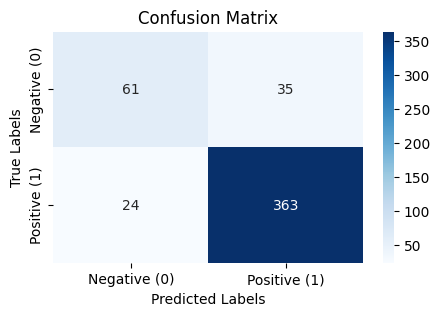

In [27]:
# Initializing the performance evaluator class for pre-trained DistilBERT
ft_dtb_performance_evaluator = ClassificationEvaluator(true_labels=dtb_test_df['sentiment'].to_list(), 
                                                       predicted_labels=ft_dtb_predictions_discrete)

ft_dtb_performance_evaluator.evaluate()
ft_dtb_performance_evaluator.plot_confusion_matrix()

In [ ]:
classifier = pipeline('sentiment-analysis',
                      model = 'distilbert-base-uncased-finetuned-sst-2-english',
                      tokenizer='distilbert-base-uncased',
                      batch_size=16)

In [ ]:
classifier('Bitcoin in 2 months. Be ready for upcoming rocket ralley.')

In [ ]:
def pipeline_classify(data):
    ''' Function to run the sentiment analysis pipeline on each row of a dataset
    and extract the scores. '''

    predictions = []

    for row in data:
          classification = classifier(row, truncation=True)[0]
          if classification['label'] == 'POSITIVE':
              predictions.append(classification['score'])
          else:
              predictions.append(1-classification['score'])
              
    return predictions

In [ ]:
bert_test_df = test_datapreprocessor.preprocess(remove_spam=True, remove_hashtags=True, remove_link=True, remove_whitespace_html=True, remove_emoji=False)

In [ ]:
bert_test_df.head()

In [ ]:
bert_pred = pipeline_classify(bert_test_df['cleaned_content'])

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

def assess_sentiment_classifier(ytest, yhat, cutoff=0.5, plot_roc=True):
    ''' Function to assess a classification model in terms of the AUC
    and classification accuracy. '''

    # Calculate discrete class predictions
    yhat_discrete = np.where(pd.DataFrame(yhat)>cutoff, 1, 0)
    # Calculate classification accuracy and AUC
    acc = accuracy_score(ytest, yhat_discrete)
    auc = roc_auc_score(ytest, yhat)
    # Confusion matrix 
    cmat = confusion_matrix(ytest, yhat_discrete)
    # ROC analysis
    if plot_roc==True:
        fpr, tpr, _ = roc_curve(ytest, yhat)
        plt.plot(fpr,tpr, label="AUC={:.4}".format(auc));
        plt.plot([0, 1], [0, 1], "r--")
        plt.ylabel('True positive rate')    
        plt.xlabel('False positive rate')    
        plt.legend(loc='lower right')
        plt.show();
    
    print("NN test set performance:\tAUC={:.4f}\tAccuracy={:.4f}".format(auc, acc))
    print('Confusion matrix:')
    print(cmat)

In [ ]:
assess_sentiment_classifier(test_labels, bert_pred)

In [ ]:
bert_pred

In [ ]:
bert_train_df = train_datapreprocessor.preprocess(remove_spam=False, remove_hashtags=True, remove_link=True, remove_whitespace_html=True)
bert_test_df = test_datapreprocessor.preprocess(remove_spam=False, remove_hashtags=True, remove_link=True, remove_whitespace_html=True)

In [ ]:
bert_train_df.head()

In [ ]:
# Dataset Preparation for Handling Tweet Data
class TweetDataset:
    def __init__(self, texts, labels=None, tokenizer=None, max_len=40):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    # Tokenize the text samples and prepares them for input into the model.
    def encode(self):
        encodings = self.tokenizer(
            self.texts,
            truncation=True,
            padding=True,
            max_length=self.max_len,
            return_tensors='tf'
        )
        return encodings
    
    # Converts the tokenized texts and labels into a TensorFlow Dataset object.
    def prepare_data(self):
        encodings = self.encode()
        if self.labels is not None:
            dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), self.labels))
        else:
            dataset = tf.data.Dataset.from_tensor_slices(dict(encodings))
        return dataset

In [ ]:
# Class to Fit Pretrained DistilBERT and Fine-Tune It
class SentimentAnalyzer:
    def __init__(self, model_name='distilbert-base-uncased', num_labels=2):
        self.tokenizer = DistilBertTokenizer.from_pretrained(model_name)
        self.model = TFDistilBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

    def fit_pretrained(self, test_texts, batch_size=16):
        test_dataset = TweetDataset(texts=test_texts, tokenizer=self.tokenizer).prepare_data()
        test_dataset = test_dataset.batch(batch_size)

        predictions = self.model.predict(test_dataset).logits
        predictions = tf.argmax(predictions, axis=-1).numpy()

        return predictions

    def fine_tune(self, train_texts, train_labels, test_texts, test_labels, batch_size=16, epochs=3):
        train_dataset = TweetDataset(texts=train_texts, labels=train_labels, tokenizer=self.tokenizer).prepare_data()
        test_dataset = TweetDataset(texts=test_texts, labels=test_labels, tokenizer=self.tokenizer).prepare_data()

        train_dataset = train_dataset.shuffle(len(train_texts)).batch(batch_size)
        test_dataset = test_dataset.batch(batch_size)
        
        # Assuming train_labels is your array of labels
        class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
        class_weight_dict = dict(enumerate(class_weights))

        #optimizer = Adam(learning_rate=5e-5)
        self.model.compile(optimizer='adam', 
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #self.model.compute_loss, 
                           metrics=['accuracy'])

        history = self.model.fit(
            train_dataset,
            validation_data=test_dataset,
            epochs=epochs,
            batch_size=batch_size,
            class_weight=class_weight_dict
        )

        return history

In [ ]:
#train_texts = bert_train_df['cleaned_content'].tolist()
#train_labels = bert_train_df['sentiment'].tolist()
test_texts = bert_test_df['cleaned_content'].tolist()
test_labels = bert_test_df['sentiment'].tolist()

In [ ]:
train_texts

In [ ]:
# Initialize the SentimentAnalyzer
sentiment_analyzer = SentimentAnalyzer()

### Pretrained predictions


In [ ]:
# Fit Pretrained DistilBERT on Test Dataset
pretrained_predictions = sentiment_analyzer.fit_pretrained(test_texts=test_texts)

In [ ]:
# Class to Evaluate the Model's Performance
class PerformanceEvaluator:
    def __init__(self):
        pass

    def evaluate(self, true_labels, predicted_labels):
        print('Classification report:\n')
        return print(classification_report(true_labels, predicted_labels))

    def plot_confusion_matrix(self, true_labels, predicted_labels):
        cm = confusion_matrix(true_labels, predicted_labels)
        plt.figure(figsize=(6, 3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative (0)', 'Positive(1)'], yticklabels=['Negative (0)', 'Positive(1)'])
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()

In [ ]:
# Initialize PerformanceEvaluator
evaluator = PerformanceEvaluator(true_labels=test_labels, predicted_labels=pretrained_predictions)
evaluator.evaluate()
evaluator.plot_confusion_matrix()

In [ ]:
np.unique(test_labels, return_counts=True)

In [ ]:
np.unique(pretrained_predictions, return_counts=True)

### Fine tuned predictions

In [ ]:
# Fine tune on train dataset and apply on test dataset
sentiment_analyzer.fine_tune(train_texts, train_labels, test_texts, test_labels)

In [ ]:
fine_tuned_predictions = sentiment_analyzer.fit_pretrained(test_texts)

In [ ]:
fine_tuned_predictions

In [ ]:
evaluator.evaluate(true_labels=test_labels, predicted_labels=fine_tuned_predictions)
evaluator.plot_confusion_matrix(true_labels=test_labels, predicted_labels=fine_tuned_predictions)

In [ ]:
print(tf.__version__)

In [ ]:
import transformers
print(transformers.__version__)